<a href="https://colab.research.google.com/github/Joanri20/modelosysimulaciondos/blob/trunk/Prediccion_de_la_Perdida_de_Clientes_en_el_Sector_Financiero.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://githubtocolab.com/Joanri20/mss_energy_project/blob/trunk/01_Proyecto_DataSet_World_Energy_Consumption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

# **Enfoques de Aprendizaje Automático para la Predicción de la Pérdida de Clientes en el Sector Financiero**


##**Carga de dependencias**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split,KFold,cross_validate, ShuffleSplit, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
import time
import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import accuracy_score,classification_report
from sklearn.metrics import precision_score, recall_score, f1_score,make_scorer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.feature_extraction import PrincipalComponentAnalysis as PCA
from mlxtend.feature_extraction import LinearDiscriminantAnalysis as LDA


datos = pd.read_csv("https://raw.githubusercontent.com/Joanri20/modelosysimulaciondos/trunk/churn.csv")
datos

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No
7039,2234-XADUH,Female,0,Yes,Yes,73,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,Yes


## Preprocesado de datos

In [2]:
from typing_extensions import final

#1.Eliminación de columna que pueden generar ruido o no aportan al modelo
datos_repetidos = datos['customerID'].duplicated().sum()
print(f"La columna 'customerID' tiene {datos_repetidos} datos repetidos.")
#Eliminamos la columna CustomerID ya que nos puede generar ruido
datos=datos.drop('customerID', axis=1)
#########################################################
#2. Se busca registros con datos faltantes
# Calcular el promedio de valores nulos por columna en el DataFrame 'datos'
promedio_valores_nulos_por_columna = datos.isnull().mean() * 100
print(promedio_valores_nulos_por_columna)

#3. Se identifica una columna con datos faltantes por lo tanto se llenan con la media
media_columna = datos['TotalCharges'].mean()
datos['TotalCharges'].fillna(media_columna, inplace=True)

#########################################################
#4. Se transforman las variables categoricas a númericas
# Cargar los datos
df = datos.copy()
# Seleccionar las columnas numéricas y categóricas
columnas_numericas = df.select_dtypes(include=[np.number]).columns.tolist()
columnas_categoricas = df.select_dtypes(exclude=[np.number]).columns.tolist()

#Se separa la columna de salida  de las columnas predictoras
columnas_categoricas.remove('Churn')

#Se trasnforman las variables predictoras que son categoricas en númericas
label_encoders = {}
for col in columnas_categoricas:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
##########################################################
#5. Transformar en númerica la variables de salida (0:NO y 1:SI)
label_encoder = LabelEncoder()
# ******Variable de salida*****
y = label_encoder.fit_transform(df['Churn'])

#Se combinan las númericas y las categoricas en una sola variable X
columnas_predictoras = columnas_numericas + columnas_categoricas
# *****Variables predictoras*****
X = df[columnas_predictoras]
#######################################################
#6. Normalizar las variables predictoras
scaler = StandardScaler()
X= pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

###########################################################
#7. Escoger datos para validación bootstrap
#Divide los datos para entrenamiento Bootstrap 80% y test 20%
X_train_bootstrap, X_test_bootstrap, y_train_bootstrap, y_test_bootstrap = train_test_split(X, y, test_size=0.2, random_state=42)
#Se elige k_fold = 10
k_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
###########################################################

#8. Selección metricas evaluar
scoring = ['accuracy', 'precision', 'recall', 'f1']

# Funcion para extraer metricas
def metricas(model):
  print(f"Accuracy: {model['test_accuracy'].mean():.4f}")
  print(f"Precision: {model['test_precision'].mean():.4f}")
  print(f"Recall: {model['test_recall'].mean():.4f}")
  print(f"F1: {model['test_f1'].mean():.4f}")
  print(f"Tiempo de entrenamiento:{model['fit_time'].mean():.4f} segundos")

###############################################################
#Tabla completa al final, estandarizada
result = pd.concat([X, pd.DataFrame(y, columns=['Churn'])], axis=1)
result

La columna 'customerID' tiene 0 datos repetidos.
gender              0.000000
SeniorCitizen       0.000000
Partner             0.000000
Dependents          0.000000
tenure              0.000000
PhoneService        0.000000
MultipleLines       0.000000
InternetService     0.000000
OnlineSecurity      0.000000
OnlineBackup        0.000000
DeviceProtection    0.000000
TechSupport         0.000000
StreamingTV         0.000000
StreamingMovies     0.000000
Contract            0.000000
PaperlessBilling    0.000000
PaymentMethod       0.000000
MonthlyCharges      0.000000
TotalCharges        0.156183
Churn               0.000000
dtype: float64


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
0,-0.439916,-1.277442,-1.160323,-0.994971,-1.009559,1.034530,-0.654012,-3.054010,0.062723,-1.183234,-0.918838,1.242550,-1.027910,-0.925262,-1.113495,-1.121405,-0.828207,0.829798,0.398558,0
1,-0.439916,0.066327,-0.259629,-0.173876,0.990532,-0.966622,-0.654012,0.327438,-0.991588,-1.183234,1.407321,-1.029919,1.245111,-0.925262,-1.113495,-1.121405,0.371271,-1.205113,1.334863,0
2,-0.439916,-1.236722,-0.362660,-0.960399,0.990532,-0.966622,-0.654012,0.327438,-0.991588,-1.183234,1.407321,1.242550,-1.027910,-0.925262,-1.113495,-1.121405,-0.828207,0.829798,1.334863,1
3,-0.439916,0.514251,-0.746535,-0.195400,0.990532,-0.966622,-0.654012,-3.054010,0.062723,-1.183234,1.407321,-1.029919,1.245111,1.396299,-1.113495,-1.121405,0.371271,-1.205113,-1.474052,0
4,-0.439916,-1.236722,0.197365,-0.941193,-1.009559,-0.966622,-0.654012,0.327438,-0.991588,0.172250,-0.918838,-1.029919,-1.027910,-0.925262,-1.113495,-1.121405,-0.828207,0.829798,0.398558,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,-0.439916,-0.340876,0.665992,-0.129281,0.990532,1.034530,1.529024,0.327438,1.117034,-1.183234,1.407321,-1.029919,1.245111,1.396299,1.146547,1.138411,0.371271,0.829798,1.334863,0
7039,-0.439916,1.654419,1.277533,2.242808,-1.009559,1.034530,1.529024,0.327438,1.117034,0.172250,-0.918838,1.242550,1.245111,-0.925262,1.146547,1.138411,0.371271,0.829798,-0.537747,0
7040,-0.439916,-0.870240,-1.168632,-0.855182,-1.009559,1.034530,1.529024,-3.054010,0.062723,-1.183234,1.407321,-1.029919,-1.027910,-0.925262,-1.113495,-1.121405,-0.828207,0.829798,0.398558,0
7041,2.273159,-1.155282,0.320338,-0.872777,0.990532,1.034530,-0.654012,0.327438,1.117034,0.172250,-0.918838,-1.029919,-1.027910,-0.925262,-1.113495,-1.121405,-0.828207,0.829798,1.334863,1


#**Implementación de modelos ML**

## **Funciones Discriminantes Gaussianas**  (Gaussian Discriminant Analysis - GDA)

###Utilizando **validacion bootstrap** para los modelos FDG donde hay 3 tipos: Sacado de la siguiente fuente: [Link](https://colab.research.google.com/github/jdariasl/ML_2020/blob/master/Clase%2003%20-%20Funciones%20discriminantes%20Gausianas.ipynb#scrollTo=oHQ2boOqZ4jM)

In [4]:
#CASO 1 : matrices de covarianza se consideran de la forma  Σ=σ2I , donde  I  es la matriz identidad.

#Entrenar el modelo
fdgC1 = LinearDiscriminantAnalysis()
start_time = time.time()
fdgC1.fit(X_train_bootstrap, y_train_bootstrap)
end_time = time.time()
training_time = end_time - start_time
#Evaluar el modelo
# Hacer predicciones
y_pred = fdgC1.predict(X_test_bootstrap)

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test_bootstrap, y_pred)
print(f'Accuracy FDG Caso 1: {accuracy}')

# Mostrar el reporte de clasificación (métricas detalladas por clase)
print('FDG Caso 1:')
print(classification_report(y_test_bootstrap, y_pred))
print(f"Tiempo entrenamiento: {training_time}")
#########################################################################
print("****************************************")
#CASO 2 : Las matrices de covarianza se consideran diagonales
#Entrenar el modelo
fdgC2 = GaussianNB()
start_time = time.time()
fdgC2.fit(X_train_bootstrap, y_train_bootstrap)
end_time = time.time()
training_time = end_time - start_time
#Evaluar el modelo
# Hacer predicciones
y_pred = fdgC2.predict(X_test_bootstrap)

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test_bootstrap, y_pred)
print(f'Accuracy FDG Caso 2: {accuracy}')

# Mostrar el reporte de clasificación (métricas detalladas por clase)
print('FDG Caso 2:')
print(classification_report(y_test_bootstrap, y_pred))
print(f"Tiempo entrenamiento: {training_time}")
#########################################################################
print("****************************************")
#CASO 3 :  Las matrices de covarianza de los modelos se consideran completas y las clases se consideran agrupadas en parábolas cuyo eje principal puede estar en cualquier dirección
#Entrenar el modelo
fdgC3 = QuadraticDiscriminantAnalysis()
start_time = time.time()
fdgC3.fit(X_train_bootstrap, y_train_bootstrap)
end_time = time.time()
training_time = end_time - start_time
#Evaluar el modelo
# Hacer predicciones
y_pred = fdgC3.predict(X_test_bootstrap)

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test_bootstrap, y_pred)
print(f'Accuracy FDG Caso 3: {accuracy}')

# Mostrar el reporte de clasificación (métricas detalladas por clase)
print('FDG Caso 3:')
print(classification_report(y_test_bootstrap, y_pred))
print(f"Tiempo entrenamiento: {training_time}")

Accuracy FDG Caso 1: 0.8168914123491838
FDG Caso 1:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      1036
           1       0.68      0.59      0.63       373

    accuracy                           0.82      1409
   macro avg       0.77      0.74      0.75      1409
weighted avg       0.81      0.82      0.81      1409

Tiempo entrenamiento: 0.01788616180419922
****************************************
Accuracy FDG Caso 2: 0.7579843860894251
FDG Caso 2:
              precision    recall  f1-score   support

           0       0.90      0.75      0.82      1036
           1       0.53      0.77      0.63       373

    accuracy                           0.76      1409
   macro avg       0.72      0.76      0.72      1409
weighted avg       0.80      0.76      0.77      1409

Tiempo entrenamiento: 0.010814189910888672
****************************************
Accuracy FDG Caso 3: 0.7707594038325053
FDG Caso 3:
              precision

### **FDG con Validación Cruzada**

In [ ]:
#CASO 1 : matrices de covarianza se consideran de la forma  Σ=σ2I , donde  I  es la matriz identidad.

cross_val_scores = cross_validate(LinearDiscriminantAnalysis(), X, y, cv=k_fold, scoring=scoring)
# Mostrar el resultado
print("\nResultado Para Caso 1:")
metricas(cross_val_scores)
#########################################################################
print("****************************************")
#CASO 2 : Las matrices de covarianza se consideran diagonales
cross_val_scores = cross_validate(GaussianNB(), X, y, cv=k_fold, scoring=scoring)
# Mostrar el resultado
print("\nResultado Para Caso 2:")
metricas(cross_val_scores)
#########################################################################
print("****************************************")
#CASO 3 :  Las matrices de covarianza de los modelos se consideran completas y las clases se consideran agrupadas en parábolas cuyo eje principal puede estar en cualquier dirección
cross_val_scores = cross_validate(QuadraticDiscriminantAnalysis(), X, y, cv=k_fold, scoring=scoring)
# Mostrar el resultado
print("\nResultado Para Caso 3:")
metricas(cross_val_scores)


Resultado Para Caso 1:
Accuracy: 0.7970
Precision: 0.6397
Recall: 0.5388
F1: 0.5844
Tiempo de entrenamiento:0.0354 segundos
****************************************

Resultado Para Caso 2:
Accuracy: 0.7521
Precision: 0.5241
Recall: 0.7341
F1: 0.6110
Tiempo de entrenamiento:0.0098 segundos
****************************************

Resultado Para Caso 3:
Accuracy: 0.7590
Precision: 0.5339
Recall: 0.7389
F1: 0.6195
Tiempo de entrenamiento:0.0122 segundos


##**Modelo de K Vecinos Más Cercanos (K-Nearest Neighbors - KNN):**

### Validación cruzada con 10 k-folds: Se realiza una busqueda de los K-vecinos mas optimos


Resultado mejor modelo:

K-Vecinos: 20
Accuracy: 0.7784
Precision: 0.6006
Recall: 0.4933
F1: 0.5411
Tiempo de entrenamiento:0.0035 segundos


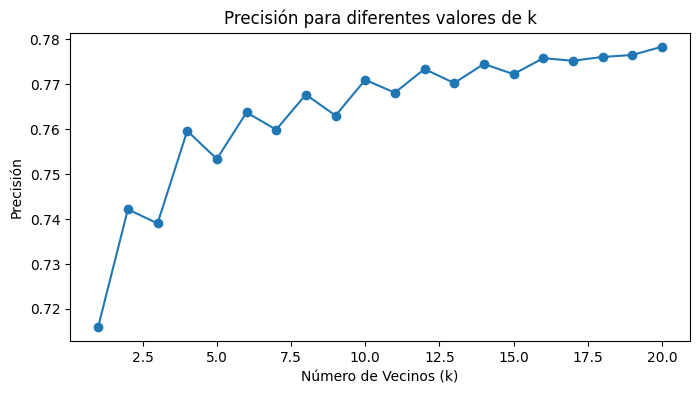

El número óptimo de vecinos es: 20 con una precision de: 0.7784


In [5]:
# Lista para almacenar las puntuaciones de precisión
precisions = []
ks = []
best_accuracy=0
best_model=0
best_k=0
# Probar diferentes valores de k
valores_k = range(1, 21)
for k in valores_k:
    knn = KNeighborsClassifier(n_neighbors=k)
    cross_val_scores = cross_validate(knn, X, y, cv=k_fold, scoring=scoring)
    mean_accuracy=cross_val_scores['test_accuracy'].mean()
    precisions.append(mean_accuracy)
    ks.append(k)
    if mean_accuracy > best_accuracy:
      best_model=cross_val_scores
      best_k=k

# Mostrar el resultado
print("\nResultado mejor modelo:")
print("\nK-Vecinos:",best_k)
metricas(best_model)

# Graficar los resultados
plt.figure(figsize=(8,4))
plt.plot(ks, precisions, marker='o')
plt.xlabel('Número de Vecinos (k)')
plt.ylabel('Precisión')
plt.title('Precisión para diferentes valores de k')
plt.show()

# Encontrar el valor de k con la mayor precisión
k_optimo = ks[precisions.index(max(precisions))]
print(f'El número óptimo de vecinos es: {k_optimo} con una precision de: {max(precisions):.4f}')

###KNN con una validación bootstrap con 20 vecinos

In [6]:
# Entrenar el modelo con 20  vecinos
knn_model = KNeighborsClassifier(n_neighbors=20)
start_time = time.time()
knn_model.fit(X_train_bootstrap, y_train_bootstrap)
end_time = time.time()
training_time = end_time - start_time
# Predecir en el conjunto de prueba
knn_predictions = knn_model.predict(X_test_bootstrap)

# Evaluar el modelo
accuracy = accuracy_score(y_test_bootstrap, knn_predictions)
print(f"Accuracy of K-Nearest Neighbors (k=20): {accuracy}")
print(classification_report(y_test_bootstrap, knn_predictions))
print(f"Tiempo entrenamiento: {training_time}")

Accuracy of K-Nearest Neighbors (k=20): 0.7863733144073811
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1036
           1       0.62      0.51      0.56       373

    accuracy                           0.79      1409
   macro avg       0.73      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409

Tiempo entrenamiento: 0.00679779052734375


## **Feed-Forward Neural Networks**


###Validación cruzada con 10 k folds

In [7]:
# Implementamos la metodología de validación cross validation con 10 folds
kf = KFold(n_splits=10, shuffle=True, random_state=42)
# Definir las épocas que queremos probar
epoch_options = [10, 20, 30]

# Inicializar listas para almacenar resultados
results = {epochs: [] for epochs in epoch_options}
for train_index, test_index in kf.split(X):
  # Preparar los datos de entrenamiento y prueba
  X_train_vc, X_test_vc = X.iloc[train_index], X.iloc[test_index]
  y_train_vc, y_test_vc = y[train_index], y[test_index]

  for epochs in epoch_options:
    # Crear un nuevo modelo cada iteracción
    model = Sequential()
    model.add(Dense(10, input_dim=X.shape[1], activation='relu'))
    model.add(Dense(2, activation='relu'))
    # Ya que se convirtió la variable de salida en binaria, podemos usar sigmoid
    model.add(Dense(1, activation='sigmoid'))

    # Compilar el modelo
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    start_time = time.time()

    # Entrenar el modelo
    model.fit(X_train_vc, y_train_vc, epochs=epochs, batch_size=32, verbose=0)

    end_time = time.time()

   # Predicciones
    y_pred_prob = model.predict(X_test_vc)
    y_pred = (y_pred_prob > 0.5).astype(int)

    # Calcular métricas
    accuracy = accuracy_score(y_test_vc, y_pred)
    precision = precision_score(y_test_vc, y_pred)
    recall = recall_score(y_test_vc, y_pred)
    f1 = f1_score(y_test_vc, y_pred)
    training_time = end_time - start_time

    # Guardar los resultados
    results[epochs].append((accuracy, precision, recall, f1,training_time))

# Promediar los resultados para cada número de épocas
averaged_results = {epochs: np.mean(results[epochs], axis=0) for epochs in epoch_options}

# Imprimir resultados
for epochs, metrics in averaged_results.items():
    print(f'Epocas: {epochs}')
    print(f'Accuracy: {metrics[0]:.4f}')
    print(f'Precision: {metrics[1]:.4f}')
    print(f'Recall: {metrics[2]:.4f}')
    print(f'F1 Score: {metrics[3]:.4f}')
    print(f'Tiempo promedio de entrenamiento:{metrics[4]:.4f} segundos')
    print('-------------------------')


22/22 [==============================] - 0s 2ms/step
Epocas: 10
Accuracy: 0.7958
Precision: 0.6474
Recall: 0.5122
F1 Score: 0.5704
Tiempo promedio de entrenamiento:5.3423 segundos
-------------------------
Epocas: 20
Accuracy: 0.7967
Precision: 0.6401
Recall: 0.5384
F1 Score: 0.5834
Tiempo promedio de entrenamiento:10.5517 segundos
-------------------------
Epocas: 30
Accuracy: 0.8014
Precision: 0.6493
Recall: 0.5464
F1 Score: 0.5917
Tiempo promedio de entrenamiento:16.2631 segundos
-------------------------


###Utilizando validación bootstrap

In [8]:
epoch_options = [10, 20, 30]
results = {epochs: [] for epochs in epoch_options}
for epochs in epoch_options:
  model = Sequential()
  model.add(Dense(10, input_dim=X.shape[1], activation='relu'))
  model.add(Dense(2, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))

  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

  start_time = time.time()

    # Entrenar el modelo
  model.fit(X_train_vc, y_train_vc, epochs=epochs, batch_size=32, verbose=0)

  end_time = time.time()

   # Predicciones
  y_pred_prob = model.predict(X_test_vc)
  y_pred = (y_pred_prob > 0.5).astype(int)

    # Calcular métricas
  accuracy = accuracy_score(y_test_vc, y_pred)
  precision = precision_score(y_test_vc, y_pred)
  recall = recall_score(y_test_vc, y_pred)
  f1 = f1_score(y_test_vc, y_pred)
  training_time = end_time - start_time

    # Guardar los resultados
  results[epochs].append((accuracy, precision, recall, f1,training_time))

# Promediar los resultados para cada número de épocas
averaged_results = {epochs: np.mean(results[epochs], axis=0) for epochs in epoch_options}

# Imprimir resultados
for epochs, metrics in averaged_results.items():
    print(f'Epocas: {epochs}')
    print(f'Accuracy: {metrics[0]:.4f}')
    print(f'Precision: {metrics[1]:.4f}')
    print(f'Recall: {metrics[2]:.4f}')
    print(f'F1 Score: {metrics[3]:.4f}')
    print(f'Tiempo promedio de entrenamiento:{metrics[4]:.4f} segundos')
    print('-------------------------')

22/22 [==============================] - 0s 2ms/step
Epocas: 10
Accuracy: 0.8082
Precision: 0.6343
Recall: 0.4971
F1 Score: 0.5574
Tiempo promedio de entrenamiento:6.0281 segundos
-------------------------
Epocas: 20
Accuracy: 0.8011
Precision: 0.6165
Recall: 0.4795
F1 Score: 0.5395
Tiempo promedio de entrenamiento:11.1014 segundos
-------------------------
Epocas: 30
Accuracy: 0.8068
Precision: 0.6336
Recall: 0.4854
F1 Score: 0.5497
Tiempo promedio de entrenamiento:11.6246 segundos
-------------------------


## **RANDOM FOREST**

###Con validación cruzada 10 kfolds y iteracciones de arboles entre 10 a 45

In [9]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Definir la cantidad de árboles a probar
tree_options = range(10, 50, 5)

# Inicializar listas para almacenar resultados
results = {B: [] for B in tree_options}

#Se realiza un for con cantidad de arboles empieza desde 10 hasta 45 de a 5
for B in tree_options:
    #Aplicando la metodología de validación

    for train_index, test_index in kf.split(X):

        X_train_vc, X_test_vc = X.iloc[train_index], X.iloc[test_index]
        y_train_vc, y_test_vc = y[train_index], y[test_index]

        #para clasificar y entrenandolo solo con las muestras de entrenamiento

        clf = RandomForestClassifier(n_estimators=B)
        start_time = time.time()
        clf.fit(X_train_vc, y_train_vc)
        end_time = time.time()

        #Complete el código aquí prediciendo la clase para las muestras de validación de la base de datos
        y_pred = clf.predict(X_test_vc)

        # Calcular métricas
        accuracy = accuracy_score(y_test_vc, y_pred)
        precision = precision_score(y_test_vc, y_pred)
        recall = recall_score(y_test_vc, y_pred)
        f1 = f1_score(y_test_vc, y_pred)
        training_time = end_time - start_time


        # Guardar los resultados
        results[B].append((accuracy, precision, recall, f1,training_time))

# Promediar los resultados para cada cantidad de árboles
averaged_results = {B: np.mean(results[B], axis=0) for B in tree_options}

# Imprimir resultados
for B, metrics in averaged_results.items():
    print(f'Número de Árboles: {B}')
    print(f'Accuracy: {metrics[0]:.4f}')
    print(f'Precision: {metrics[1]:.4f}')
    print(f'Recall: {metrics[2]:.4f}')
    print(f'F1 Score: {metrics[3]:.4f}')
    print(f'Tiempo promedio de entrenamiento:{metrics[4]:.4f} segundos')
    print('-------------------------')

Número de Árboles: 10
Accuracy: 0.7806
Precision: 0.6224
Recall: 0.4402
F1 Score: 0.5148
Tiempo promedio de entrenamiento:0.0871 segundos
-------------------------
Número de Árboles: 15
Accuracy: 0.7860
Precision: 0.6213
Recall: 0.4968
F1 Score: 0.5510
Tiempo promedio de entrenamiento:0.1259 segundos
-------------------------
Número de Árboles: 20
Accuracy: 0.7870
Precision: 0.6362
Recall: 0.4638
F1 Score: 0.5356
Tiempo promedio de entrenamiento:0.1697 segundos
-------------------------
Número de Árboles: 25
Accuracy: 0.7856
Precision: 0.6232
Recall: 0.4861
F1 Score: 0.5449
Tiempo promedio de entrenamiento:0.2549 segundos
-------------------------
Número de Árboles: 30
Accuracy: 0.7869
Precision: 0.6328
Recall: 0.4672
F1 Score: 0.5368
Tiempo promedio de entrenamiento:0.3157 segundos
-------------------------
Número de Árboles: 35
Accuracy: 0.7887
Precision: 0.6304
Recall: 0.4931
F1 Score: 0.5523
Tiempo promedio de entrenamiento:0.2889 segundos
-------------------------
Número de Árbole

###Con validación Bootstrap

In [10]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Definir la cantidad de árboles a probar
tree_options = range(10, 50, 5)

# Inicializar listas para almacenar resultados
results = {B: [] for B in tree_options}

#Se realiza un for con cantidad de arboles empieza desde 10 hasta 45 de a 5
for B in tree_options:
        #para clasificar y entrenandolo solo con las muestras de entrenamiento

  clf = RandomForestClassifier(n_estimators=B)
  start_time = time.time()
  clf.fit(X_train_bootstrap, y_train_bootstrap)
  end_time = time.time()
        #Complete el código aquí prediciendo la clase para las muestras de validación de la base de datos

  y_pred = clf.predict(X_test_bootstrap)
  # Calcular métricas
  accuracy = accuracy_score(y_test_bootstrap, y_pred)
  precision = precision_score(y_test_bootstrap, y_pred)
  recall = recall_score(y_test_bootstrap, y_pred)
  f1 = f1_score(y_test_bootstrap, y_pred)
  training_time = end_time - start_time

  # Guardar los resultados
  results[B].append((accuracy, precision, recall, f1,training_time))

# Promediar los resultados para cada cantidad de árboles
averaged_results = {B: np.mean(results[B], axis=0) for B in tree_options}

# Imprimir resultados
for B, metrics in averaged_results.items():
    print(f'Número de Árboles: {B}')
    print(f'Accuracy: {metrics[0]:.4f}')
    print(f'Precision: {metrics[1]:.4f}')
    print(f'Recall: {metrics[2]:.4f}')
    print(f'F1 Score: {metrics[3]:.4f}')
    print(f'Tiempo promedio de entrenamiento:{metrics[4]:.4f} segundos')
    print('-------------------------')

Número de Árboles: 10
Accuracy: 0.7871
Precision: 0.6431
Recall: 0.4397
F1 Score: 0.5223
Tiempo promedio de entrenamiento:0.1177 segundos
-------------------------
Número de Árboles: 15
Accuracy: 0.7963
Precision: 0.6514
Recall: 0.4960
F1 Score: 0.5632
Tiempo promedio de entrenamiento:0.1745 segundos
-------------------------
Número de Árboles: 20
Accuracy: 0.7928
Precision: 0.6653
Recall: 0.4370
F1 Score: 0.5275
Tiempo promedio de entrenamiento:0.2278 segundos
-------------------------
Número de Árboles: 25
Accuracy: 0.7892
Precision: 0.6397
Recall: 0.4665
F1 Score: 0.5395
Tiempo promedio de entrenamiento:0.2874 segundos
-------------------------
Número de Árboles: 30
Accuracy: 0.7977
Precision: 0.6642
Recall: 0.4772
F1 Score: 0.5554
Tiempo promedio de entrenamiento:0.3616 segundos
-------------------------
Número de Árboles: 35
Accuracy: 0.7984
Precision: 0.6561
Recall: 0.5013
F1 Score: 0.5684
Tiempo promedio de entrenamiento:0.3952 segundos
-------------------------
Número de Árbole

## **Modelo de Máquinas de Vectores de Soporte (Support Vector Machines - SVM):**

###Utilizando validación cruzada

In [11]:
C_values = [0.1, 1, 10,100]
gamma_values = [0.1, 0.01, 0.001, 0.0001]
kernel = 'rbf'
precision_scorer = make_scorer(precision_score, zero_division=1)
resultados = []
best_accuracy = 0

bestC=0
bestGamma=0
timeB=0
best_score=0
best_params=0
best_model=0
k_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
for C in C_values:
    for gamma in gamma_values:
      # Inicializar el modelo SVM con los parámetros
      svm_model = SVC(decision_function_shape='ovr',C=C, gamma=gamma, kernel=kernel)
      cv_results = cross_validate(svm_model, X, y, cv=k_fold, scoring={'accuracy': 'accuracy', 'precision': precision_scorer, 'recall': 'recall', 'f1': 'f1'})
      # Promediar las métricas
      avg_accuracy = np.mean(cv_results['test_accuracy'])
      avg_precision = np.mean(cv_results['test_precision'])
      avg_recall = np.mean(cv_results['test_recall'])
      avg_f1 = np.mean(cv_results['test_f1'])
      avg_time = np.mean(cv_results['fit_time'])

      # Imprimir resultados
      print(f'C: {C}, gamma: {gamma}')
      metricas(cv_results)
      print('-------------------------')

      # Verificar si este modelo es el mejor hasta ahora
      if avg_f1 > best_score:  # Usar F1 score para determinar el mejor modelo
          best_score = avg_f1
          best_params = (C, gamma)
          best_model = cv_results

# Imprimir el mejor modelo y sus parámetros
print("#####################################################")
print("Mejor Modelo\n")
print("Valor de C:",best_params[0])
print("Valor de gamma:",best_params[1])
metricas(best_model)

C: 0.1, gamma: 0.1
Accuracy: 0.7873
Precision: 0.6898
Recall: 0.3633
F1: 0.4753
Tiempo de entrenamiento:2.0206 segundos
-------------------------
C: 0.1, gamma: 0.01
Accuracy: 0.7901
Precision: 0.6808
Recall: 0.4007
F1: 0.5037
Tiempo de entrenamiento:1.4852 segundos
-------------------------
C: 0.1, gamma: 0.001
Accuracy: 0.7346
Precision: 1.0000
Recall: 0.0000
F1: 0.0000
Tiempo de entrenamiento:1.2647 segundos
-------------------------
C: 0.1, gamma: 0.0001
Accuracy: 0.7346
Precision: 1.0000
Recall: 0.0000
F1: 0.0000
Tiempo de entrenamiento:1.2621 segundos
-------------------------
C: 1, gamma: 0.1
Accuracy: 0.7921
Precision: 0.6468
Recall: 0.4805
F1: 0.5505
Tiempo de entrenamiento:1.6291 segundos
-------------------------
C: 1, gamma: 0.01
Accuracy: 0.7970
Precision: 0.6707
Recall: 0.4633
F1: 0.5475
Tiempo de entrenamiento:1.2090 segundos
-------------------------
C: 1, gamma: 0.001
Accuracy: 0.7964
Precision: 0.6757
Recall: 0.4521
F1: 0.5407
Tiempo de entrenamiento:1.2454 segundos
-

###Utilizando Bootstrap

In [12]:
C_values = [0.1, 1, 10,100]
gamma_values = [0.1, 0.01, 0.001, 0.0001]
kernel = 'rbf'

best_acc=0
best_metric=0

for C in C_values:
    for gamma in gamma_values:

      # Inicializar el modelo SVM con los parámetros
      svm_model = SVC(decision_function_shape='ovr',C=C, gamma=gamma, kernel=kernel)
      start_time = time.time()
      svm_model.fit(X_train_bootstrap, y_train_bootstrap)
      end_time = time.time()
      y_pred = svm_model.predict(X_test_bootstrap)
  # Calcular métricas
      accuracy = accuracy_score(y_test_bootstrap, y_pred)
      precision = precision_score(y_test_bootstrap, y_pred, zero_division=0)
      recall = recall_score(y_test_bootstrap, y_pred)
      f1 = f1_score(y_test_bootstrap, y_pred, zero_division=0)
      training_time = end_time - start_time
      if accuracy > best_acc:
        best_acc=accuracy
        best_metric=(C,gamma,accuracy, precision, recall, f1,training_time)

      # Evaluar el modelo
      # Evaluar el modelo
      print(f"C: {C}, gamma:{gamma}")
      print(f'Accuracy: {accuracy:.4f}')
      print(f'Precision: {precision:.4f}')
      print(f'Recall: {recall:.4f}')
      print(f'F1 Score: {f1:.4f}')
      print(f'Tiempo promedio de entrenamiento: {training_time:.4f} segundos')
      print('-------------------------')


# Imprimir resultados
print("#####################################################")
print("Mejor Modelo\n")
print(f"C: {best_metric[0]}, gamma:{best_metric[1]}")
print(f'Accuracy: {best_metric[2]:.4f}')
print(f'Precision: {best_metric[3]:.4f}')
print(f'Recall: {best_metric[4]:.4f}')
print(f'F1 Score: {best_metric[5]:.4f}')
print(f'Tiempo promedio de entrenamiento:{best_metric[6]:.4f} segundos')
print('-------------------------')



C: 0.1, gamma:0.1
Accuracy: 0.7970
Precision: 0.7143
Recall: 0.3887
F1 Score: 0.5035
Tiempo promedio de entrenamiento: 1.4596 segundos
-------------------------
C: 0.1, gamma:0.01
Accuracy: 0.8020
Precision: 0.7217
Recall: 0.4102
F1 Score: 0.5231
Tiempo promedio de entrenamiento: 1.5090 segundos
-------------------------
C: 0.1, gamma:0.001
Accuracy: 0.7353
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Tiempo promedio de entrenamiento: 0.9278 segundos
-------------------------
C: 0.1, gamma:0.0001
Accuracy: 0.7353
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Tiempo promedio de entrenamiento: 0.8838 segundos
-------------------------
C: 1, gamma:0.1
Accuracy: 0.8034
Precision: 0.6678
Recall: 0.5121
F1 Score: 0.5797
Tiempo promedio de entrenamiento: 1.1695 segundos
-------------------------
C: 1, gamma:0.01
Accuracy: 0.8183
Precision: 0.7127
Recall: 0.5255
F1 Score: 0.6049
Tiempo promedio de entrenamiento: 0.8472 segundos
-------------------------
C: 1, gamma:0.001
Accuracy: 0.8

##Selección de los 3 mejores modelos

### Se escogen los 3 mejores modelos evaluados por validación cruzada y seleccionado por su accuracy

<table>
  <tr>
  <tr bgcolor="#AAAAAA">
        <th></th>
        <th></th>
        <th bgcolor="#AAAAAA">Accuracy Model</th>
        <th> </th>
        <th></th>
        <th></th>     
  </tr>
    <tr>
        <th bgcolor="#AAAAAA">Validación/Modelos</th>
        <th>Funciones Discriminantes Gaussianas (FDG)</th>
        <th>Modelo de K Vecinos Más Cercanos (KNN)</th>
        <th>Feed-Forward Neural Networks (FFNN)</th>
        <th>Random Forest</th>
        <th>Máquinas de Vectores de Soporte (SVM)</th>  
          
  </tr>
   <tr>
    <th bgcolor="#AABBCC">Bootstrap</th>
    <td>81.68%</td>
    <td>77.85%</td>
    <td>81.11%</td>
    <td>79.98%</td>
    <td>82.04%</td>
  </tr>
  <tr>
    <th bgcolor="#AABBCC">Cross Validation</th>
    <td bgcolor="#50AA00">79.66%</td>
    <td>77.79%</td>
    <td bgcolor="#D6F9ED">80.05%</td>
    <td bgcolor="#50AA00">79.63%</td>
    <td bgcolor="#50AA00">79.63%</td>
  </tr>
   <tr>
    <th bgcolor="#AABBCC">Tiempo entrenamiento + Validation Cruzada</th>
    <td>0.0660 s </td>
    <td>0.0036 s</td>
    <td>11.3416 s</td>
    <td>0.4068 s</td>
    <td>1.2189 s</td>
  </tr>
  <tr>
    <th bgcolor="#AABBCC">Mejores Hiperparametros</th>
    <td>N/A</td>
    <td>KN:20</td>
    <td>Epocas:20</td>
    <td>Arboles:35</td>
    <td>C:100, gamma:0.0001</td>
  </tr>
  </tr>
</table>

Los mejores modelos son FDG, FFNN, y SVM, aunque este ultimo tiene un empate con Random Forest, se decide incluir Random Forest y cambiarlo por FFNN.
Debido que primero que todo su costo computacional es muy alto superando a todo los otros modelos, y segundo para realizar reducción con FFNN no encontramos la forma de desarrollarlos, ya que hay que enviar como parametro el modelo ya diseñado con sus variables de entrada y este no es posible ya que cuando se está realizando la reducción con SFS, estos deben ir cambiando la cantidad de parametros de entrada, para lo cual el modelo ya prestablecido no permite esto

## Reducción de dimensión por selección de características

###Instanciar los modelos con mejores resultado y con sus mejores hiperparametros

In [ ]:
#1 Modelo FDG
modelo1 = LinearDiscriminantAnalysis()
modelo1_mejoresCaracteristicas=0
#2 Modelo RandomForest
modelo2 = RandomForestClassifier(n_estimators=35)
modelo2_mejoresCaracteristicas=0

#3 Modelo SVC
modelo3 = SVC(decision_function_shape='ovr',C=100, gamma=0.0001, kernel='rbf')
modelo3_mejoresCaracteristicas=0

mejores_modelo=[modelo1,modelo2,modelo3]
nombres_modelos = {
    modelo1: "FDG",
    modelo2: "RandomForest",
    modelo3: "SVC",
}
mejores_caracteristicas=0

### Creación de función para evaluar mejores caracteristicas a un modelo

In [ ]:
def select_features(modelo, n_features, fwd, fltg):

    sfs = SFS(modelo,
          k_features=n_features,
          forward=fwd,
          floating=fltg,
          scoring='accuracy',
          cv=k_fold,
          n_jobs=-1)

    return sfs

def reduccion_caracteristicas(modelo_evaluar,cantidades_caracteristicas,sfs):

  for modelo in modelo_evaluar:
    mejor=0
    nombre = nombres_modelos.get(modelo, "Modelo desconocido")
    for n_features in cantidades_caracteristicas:
      for sfs_c in sfs:
          start_time = time.time()
          sf = select_features(modelo, n_features=n_features, fwd=sfs_c, fltg=False)
          sf = sf.fit(X, y)
          # Imprimir características seleccionadas
          selected_features = sf.k_feature_idx_
          sfs_u = "SFS" if sfs_c else "SBS"
          # Obtener y visualizar las puntuaciones de validación cruzada
          grid_scores = sf.get_metric_dict()
          eficiencia= grid_scores[n_features]['avg_score']
          end_time = time.time()
          tiempo_entrenamiento = end_time - start_time
          print(f"\n ----------------------------------------------\n Modelo evaluando: {nombre}\n Para {n_features} caracteristicas\n Utilizando {sfs_u}\n Selección de variables: {selected_features}\n Nombre de las caracteristicas seleccionadas:{sf.k_feature_names_}\n Eficiencia: {eficiencia}\n Tiempo de entrenamiento: {tiempo_entrenamiento:.2f} segundos \n ------------------------------------------------------ \n")

          if eficiencia > mejor:
            mejor=eficiencia
            mejores_caracteristicas=[n_features,selected_features,sfs_u,eficiencia,tiempo_entrenamiento,nombre,sf.k_feature_names_]
    print("#########################################################")
  print("#########################################################")
  print(f"\n ***************************************************\n Mejores Caracteristicas para el modelo {mejores_caracteristicas[5]}:\n # Caracteristicas:{mejores_caracteristicas[0]} y con las caracteristicas:{mejores_caracteristicas[1]}\nEstrategia:{mejores_caracteristicas[2]},  con la eficiencia:{mejores_caracteristicas[3]:.4f} y tiempo de:{mejores_caracteristicas[4]:.2f} segundos\n Nombre caracteristicas Seleccionadas:{mejores_caracteristicas[6]}\n *********************************************************\n")

  if mejores_caracteristicas[5]=="FDG":
    modelo1_mejoresCaracteristicas=mejores_caracteristicas
  elif mejores_caracteristicas[5]=="RandomForest":
    modelo2_mejoresCaracteristicas=mejores_caracteristicas
  elif mejores_caracteristicas[5]=="SVC":
    modelo3_mejoresCaracteristicas=mejores_caracteristicas


###Utilizando Funciones en paralelo para seleccionar mejores caracteristicas

Cantidad_caracteristicas, un array con cantidad de caracteristicas a las cuales queremos reducir y evaluar.
Por ejemplo: en el array tenemos el numero 3, quiere decir que queremos reducir a 3 caracteristicas nuestro dataset y evaluar su eficiencia y sucesivamente con cada uno de los valores en su array

sfs: False para utilizar estrategia Sequencial Backward Selection (SBS)--
True para utilizar estrategia Sequencial Forward Selection (SFS)


**NOTA IMPORTANTE ANTES DE EJECUTAR**: El proceso dura al rededor de 1 hora

In [ ]:
import concurrent.futures
cantidades_caracteristicas = [3,7,11,14,17]
sfs = [False, True]

# Ejecuta la función en paralelo
with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = []
    for modelo in [modelo1, modelo2, modelo3]:
        future = executor.submit(reduccion_caracteristicas, [modelo], cantidades_caracteristicas, sfs)
        futures.append(future)

    # Espera a que todas las tareas se completen
    concurrent.futures.wait(futures)

c:\Users\Joan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
c:\Users\Joan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(



 ----------------------------------------------
 Modelo evaluando: FDG
 Para 3 caracteristicas
 Utilizando SBS
 Selección de variables: (1, 2, 7)
 Nombre de las caracteristicas seleccionadas:('tenure', 'MonthlyCharges', 'PhoneService')
 Eficiencia: 0.7884393133462282
 Tiempo de entrenamiento: 69.09 segundos 
 ------------------------------------------------------ 


 ----------------------------------------------
 Modelo evaluando: FDG
 Para 3 caracteristicas
 Utilizando SFS
 Selección de variables: (0, 1, 2)
 Nombre de las caracteristicas seleccionadas:('SeniorCitizen', 'tenure', 'MonthlyCharges')
 Eficiencia: 0.7904261363636363
 Tiempo de entrenamiento: 1.87 segundos 
 ------------------------------------------------------ 



c:\Users\Joan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(



 ----------------------------------------------
 Modelo evaluando: FDG
 Para 7 caracteristicas
 Utilizando SBS
 Selección de variables: (1, 2, 7, 8, 10, 13, 17)
 Nombre de las caracteristicas seleccionadas:('tenure', 'MonthlyCharges', 'PhoneService', 'MultipleLines', 'OnlineSecurity', 'TechSupport', 'PaperlessBilling')
 Eficiencia: 0.7986633623468731
 Tiempo de entrenamiento: 52.09 segundos 
 ------------------------------------------------------ 


 ----------------------------------------------
 Modelo evaluando: FDG
 Para 7 caracteristicas
 Utilizando SFS
 Selección de variables: (0, 1, 2, 7, 14, 15, 16)
 Nombre de las caracteristicas seleccionadas:('SeniorCitizen', 'tenure', 'MonthlyCharges', 'PhoneService', 'StreamingTV', 'StreamingMovies', 'Contract')
 Eficiencia: 0.7978090747904578
 Tiempo de entrenamiento: 41.83 segundos 
 ------------------------------------------------------ 



c:\Users\Joan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(



 ----------------------------------------------
 Modelo evaluando: FDG
 Para 11 caracteristicas
 Utilizando SBS
 Selección de variables: (0, 1, 2, 7, 8, 9, 10, 11, 12, 13, 17)
 Nombre de las caracteristicas seleccionadas:('SeniorCitizen', 'tenure', 'MonthlyCharges', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'PaperlessBilling')
 Eficiencia: 0.8013604126370083
 Tiempo de entrenamiento: 92.71 segundos 
 ------------------------------------------------------ 


 ----------------------------------------------
 Modelo evaluando: FDG
 Para 11 caracteristicas
 Utilizando SFS
 Selección de variables: (0, 1, 2, 4, 5, 6, 7, 14, 15, 16, 18)
 Nombre de las caracteristicas seleccionadas:('SeniorCitizen', 'tenure', 'MonthlyCharges', 'gender', 'Partner', 'Dependents', 'PhoneService', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod')
 Eficiencia: 0.7941187137330756
 Tiempo de entrenamiento: 40.66 segundos 
 ---

c:\Users\Joan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(



 ----------------------------------------------
 Modelo evaluando: FDG
 Para 14 caracteristicas
 Utilizando SBS
 Selección de variables: (0, 1, 2, 4, 6, 7, 8, 9, 10, 11, 12, 13, 16, 17)
 Nombre de las caracteristicas seleccionadas:('SeniorCitizen', 'tenure', 'MonthlyCharges', 'gender', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'Contract', 'PaperlessBilling')
 Eficiencia: 0.8016436976144423
 Tiempo de entrenamiento: 146.96 segundos 
 ------------------------------------------------------ 


 ----------------------------------------------
 Modelo evaluando: FDG
 Para 14 caracteristicas
 Utilizando SFS
 Selección de variables: (0, 1, 2, 4, 5, 6, 7, 8, 9, 14, 15, 16, 17, 18)
 Nombre de las caracteristicas seleccionadas:('SeniorCitizen', 'tenure', 'MonthlyCharges', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'StreamingTV', 'StreamingMovies', 'Contract', 'P

c:\Users\Joan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(



 ----------------------------------------------
 Modelo evaluando: FDG
 Para 17 caracteristicas
 Utilizando SBS
 Selección de variables: (0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18)
 Nombre de las caracteristicas seleccionadas:('SeniorCitizen', 'tenure', 'MonthlyCharges', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod')
 Eficiencia: 0.8022118794326241
 Tiempo de entrenamiento: 2.39 segundos 
 ------------------------------------------------------ 


 ----------------------------------------------
 Modelo evaluando: RandomForest
 Para 3 caracteristicas
 Utilizando SBS
 Selección de variables: (0, 2, 3)
 Nombre de las caracteristicas seleccionadas:('SeniorCitizen', 'MonthlyCharges', 'TotalCharges')
 Eficiencia: 0.7662882817537072
 Tiempo de entrenamiento: 460.85 segundos 
 ---------------------------

c:\Users\Joan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(



 ----------------------------------------------
 Modelo evaluando: RandomForest
 Para 7 caracteristicas
 Utilizando SBS
 Selección de variables: (0, 2, 3, 4, 8, 17, 18)
 Nombre de las caracteristicas seleccionadas:('SeniorCitizen', 'MonthlyCharges', 'TotalCharges', 'gender', 'MultipleLines', 'PaperlessBilling', 'PaymentMethod')
 Eficiencia: 0.7814811009026436
 Tiempo de entrenamiento: 218.41 segundos 
 ------------------------------------------------------ 


 ----------------------------------------------
 Modelo evaluando: RandomForest
 Para 7 caracteristicas
 Utilizando SFS
 Selección de variables: (1, 2, 5, 6, 7, 8, 9)
 Nombre de las caracteristicas seleccionadas:('tenure', 'MonthlyCharges', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService')
 Eficiencia: 0.7635890151515151
 Tiempo de entrenamiento: 52.87 segundos 
 ------------------------------------------------------ 



c:\Users\Joan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(



 ----------------------------------------------
 Modelo evaluando: SVC
 Para 3 caracteristicas
 Utilizando SBS
 Selección de variables: (1, 2, 13)
 Nombre de las caracteristicas seleccionadas:('tenure', 'MonthlyCharges', 'TechSupport')
 Eficiencia: 0.7843214055448098
 Tiempo de entrenamiento: 805.98 segundos 
 ------------------------------------------------------ 


 ----------------------------------------------
 Modelo evaluando: RandomForest
 Para 11 caracteristicas
 Utilizando SBS
 Selección de variables: (1, 2, 3, 5, 7, 8, 9, 10, 11, 16, 18)
 Nombre de las caracteristicas seleccionadas:('tenure', 'MonthlyCharges', 'TotalCharges', 'Partner', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'Contract', 'PaymentMethod')
 Eficiencia: 0.7827599129593811
 Tiempo de entrenamiento: 122.84 segundos 
 ------------------------------------------------------ 


 ----------------------------------------------
 Modelo evaluando: SVC
 Para 3 caracteristicas


c:\Users\Joan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(



 ----------------------------------------------
 Modelo evaluando: RandomForest
 Para 11 caracteristicas
 Utilizando SFS
 Selección de variables: (0, 1, 2, 3, 6, 7, 8, 9, 10, 11, 18)
 Nombre de las caracteristicas seleccionadas:('SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'PaymentMethod')
 Eficiencia: 0.7831860493230174
 Tiempo de entrenamiento: 159.79 segundos 
 ------------------------------------------------------ 



c:\Users\Joan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(



 ----------------------------------------------
 Modelo evaluando: RandomForest
 Para 14 caracteristicas
 Utilizando SBS
 Selección de variables: (1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 13, 15, 17, 18)
 Nombre de las caracteristicas seleccionadas:('tenure', 'MonthlyCharges', 'TotalCharges', 'gender', 'Partner', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'TechSupport', 'StreamingMovies', 'PaperlessBilling', 'PaymentMethod')
 Eficiencia: 0.789292392005158
 Tiempo de entrenamiento: 216.43 segundos 
 ------------------------------------------------------ 


 ----------------------------------------------
 Modelo evaluando: RandomForest
 Para 14 caracteristicas
 Utilizando SFS
 Selección de variables: (0, 1, 2, 3, 6, 7, 8, 9, 10, 11, 13, 15, 16, 18)
 Nombre de las caracteristicas seleccionadas:('SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', '

c:\Users\Joan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(



 ----------------------------------------------
 Modelo evaluando: RandomForest
 Para 17 caracteristicas
 Utilizando SBS
 Selección de variables: (0, 1, 2, 3, 4, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18)
 Nombre de las caracteristicas seleccionadas:('SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'gender', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod')
 Eficiencia: 0.7919898452611218
 Tiempo de entrenamiento: 20.98 segundos 
 ------------------------------------------------------ 


 ----------------------------------------------
 Modelo evaluando: SVC
 Para 7 caracteristicas
 Utilizando SBS
 Selección de variables: (0, 1, 2, 10, 11, 13, 17)
 Nombre de las caracteristicas seleccionadas:('SeniorCitizen', 'tenure', 'MonthlyCharges', 'OnlineSecurity', 'OnlineBackup', 'TechSupport', 'PaperlessBilling')
 Eficiencia: 0.7

c:\Users\Joan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(



 ----------------------------------------------
 Modelo evaluando: SVC
 Para 11 caracteristicas
 Utilizando SBS
 Selección de variables: (0, 1, 2, 7, 8, 10, 11, 12, 13, 17, 18)
 Nombre de las caracteristicas seleccionadas:('SeniorCitizen', 'tenure', 'MonthlyCharges', 'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'PaperlessBilling', 'PaymentMethod')
 Eficiencia: 0.8015034655061252
 Tiempo de entrenamiento: 579.64 segundos 
 ------------------------------------------------------ 


 ----------------------------------------------
 Modelo evaluando: SVC
 Para 11 caracteristicas
 Utilizando SFS
 Selección de variables: (0, 1, 2, 4, 7, 8, 10, 13, 15, 16, 17)
 Nombre de las caracteristicas seleccionadas:('SeniorCitizen', 'tenure', 'MonthlyCharges', 'gender', 'PhoneService', 'MultipleLines', 'OnlineSecurity', 'TechSupport', 'StreamingMovies', 'Contract', 'PaperlessBilling')
 Eficiencia: 0.8000832124435849
 Tiempo de entrenamiento: 258.21

c:\Users\Joan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(



 ----------------------------------------------
 Modelo evaluando: SVC
 Para 14 caracteristicas
 Utilizando SBS
 Selección de variables: (0, 1, 2, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18)
 Nombre de las caracteristicas seleccionadas:('SeniorCitizen', 'tenure', 'MonthlyCharges', 'Dependents', 'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod')
 Eficiencia: 0.8022120809155384
 Tiempo de entrenamiento: 504.44 segundos 
 ------------------------------------------------------ 


 ----------------------------------------------
 Modelo evaluando: SVC
 Para 14 caracteristicas
 Utilizando SFS
 Selección de variables: (0, 1, 2, 3, 4, 7, 8, 10, 11, 13, 15, 16, 17, 18)
 Nombre de las caracteristicas seleccionadas:('SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'gender', 'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'TechSupport', 'StreamingMovies

c:\Users\Joan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(



 ----------------------------------------------
 Modelo evaluando: SVC
 Para 17 caracteristicas
 Utilizando SBS
 Selección de variables: (0, 1, 2, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18)
 Nombre de las caracteristicas seleccionadas:('SeniorCitizen', 'tenure', 'MonthlyCharges', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod')
 Eficiencia: 0.8009346792392005
 Tiempo de entrenamiento: 94.47 segundos 
 ------------------------------------------------------ 


 ----------------------------------------------
 Modelo evaluando: SVC
 Para 17 caracteristicas
 Utilizando SFS
 Selección de variables: (0, 1, 2, 3, 4, 5, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18)
 Nombre de las caracteristicas seleccionadas:('SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'gender', 'Partner', 'PhoneService', 'MultipleLines'

##Extracción de caracteristicas

Utilizando estrategia PCA

In [ ]:
mejores_extraccion=0
mejores_extraccion1=0
mejores_extraccion2=0
mejores_extraccion3=0

In [ ]:
def classification_error(y_est, y_real):
    err = 0
    for y_e, y_r in zip(y_est, y_real):

        if y_e != y_r:
            err += 1

    return err/np.size(y_est)

def extraccion_caracteristicas(modelo_evaluar,componentes_principales):

  for modelo in modelo_evaluar:
    nombre = nombres_modelos.get(modelo, "Modelo desconocido")
    mejor=0
    for n_componentes in componentes_principales:
      Errores = np.ones(10)
      j = 0
      kf = KFold(n_splits=10)
      start_time = time.time()

      for train_index, test_index in kf.split(X):
          ex = PCA(n_components=n_componentes)
          ex.fit(X.iloc[train_index])
          X_ex = ex.transform(X)
          X_train, X_test = X_ex.iloc[train_index], X_ex.iloc[test_index]
          y_train, y_test = y[train_index], y[test_index]
          model = modelo.fit(X_train,y_train)
          ypred = model.predict(X_test)
          Errores[j] = classification_error(ypred, y_test)
          j+=1
      end_time = time.time()
      tiempo_entrenamiento = end_time - start_time
      eficiencia=(1-np.mean(Errores))
      print(f"\n ----------------------------------------------\n Modelo evaluando: {nombre}\n Para {n_componentes} Componentes\n Eficiencia: {eficiencia:.4f}\n Tiempo de entrenamiento: {tiempo_entrenamiento:.2f} segundos \n ------------------------------------------------------ \n")
      if eficiencia > mejor:
            mejor=eficiencia
            mejores_extraccion=[nombre,n_componentes,eficiencia,tiempo_entrenamiento]
      print("#########################################################")
    print("#########################################################")
    print(f"\n ***************************************************\n Mejores Componentes para el modelo {mejores_extraccion[0]}:\n # Componentes:{mejores_extraccion[1]}\n la eficiencia:{mejores_extraccion[2]:.4f} y tiempo de entrenamientos de:{mejores_extraccion[3]:.2f} segundos \n *********************************************************\n")

    if mejores_extraccion[0]=="FDG":
      mejores_extraccion1=mejores_extraccion
    elif mejores_extraccion[0]=="RandomForest":
      mejores_extraccion2=mejores_extraccion
    elif mejores_extraccion[0]=="SVC":
      mejores_extraccion3=mejores_extraccion

###Utilizando funciones en paralelo para extracción componentes

In [ ]:
import concurrent.futures
cantidades_componentes = [3,7,11,14,17]

# Ejecuta la función en paralelo
with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = []
    for modelo in [modelo1, modelo2, modelo3]:
        future = executor.submit(extraccion_caracteristicas, [modelo], cantidades_componentes)
        futures.append(future)

    # Espera a que todas las tareas se completen
    concurrent.futures.wait(futures)


 ----------------------------------------------
 Modelo evaluando: FDG
 Para 3 Componentes
 Eficiencia: 0.7850
 Tiempo de entrenamiento: 36.91 segundos 
 ------------------------------------------------------ 

#########################################################

 ----------------------------------------------
 Modelo evaluando: RandomForest
 Para 3 Componentes
 Eficiencia: 0.7623
 Tiempo de entrenamiento: 48.47 segundos 
 ------------------------------------------------------ 

#########################################################

 ----------------------------------------------
 Modelo evaluando: SVC
 Para 3 Componentes
 Eficiencia: 0.7846
 Tiempo de entrenamiento: 58.41 segundos 
 ------------------------------------------------------ 

#########################################################

 ----------------------------------------------
 Modelo evaluando: FDG
 Para 7 Componentes
 Eficiencia: 0.7866
 Tiempo de entrenamiento: 33.73 segundos 
 --------------------------

<table>
  <tr>
  <tr bgcolor="#AAAAAA">
        <th></th>
        <th></th>
        <th><b>Selección de caracteristicas</th>        
        <th></th>     
  </tr>
    <tr>
        <th bgcolor="#AAAAAA">Validación/Modelos</th>
        <th>Funciones Discriminantes Gaussianas (FDG)</th>        
        <th>Random Forest</th>
        <th>Máquinas de Vectores de Soporte (SVM)</th>  
          
  </tr>

  <tr>
    <th bgcolor="#AABBCC">Accuray por selección (SFS-SBS)</th>
    <td bgcolor="#D6EEF9"><b>80.22% -> 17 Caracteristicas</td>    
    <td bgcolor="#D6EEF9"><b>79.20% -> 17 Caracteristicas</td>
    <td bgcolor="#D6EEF9"><b>80.24% -> 14 Caracteristicas</td>
  </tr>
   <tr>
    <th bgcolor="#AABBCC">Caracteristicas Seleccionadas</th>
    <td bgcolor="#B8E9EC">0,1,2,4,5,6,7,8,9,10,11,12,13,15,16,17,18</td>  
    <td bgcolor="#B8E9EC">0,1,2,3,4,7,8,9,10,11,12,13,14,15,16,17,18</td>
    <td bgcolor="#B8E9EC">0,1,2,3,4,7,8,10,11,13,15,16,17,18</td>
  </tr>
  <tr>
    <th bgcolor="#AABBCC">Accuracy por extracción (PCA) </th>
    <td bgcolor="#D6EEF9"><b>79.07% -> 17 Componentes</td>   
    <td bgcolor="#D6EEF9"><b>77.52% -> 17 componentes</td>
    <td bgcolor="#D6EEF9"><b>79.31% -> 17 componentes</td>
  </tr>
  </tr>
</table>

Mejores características encontradas por el mejor modelo.
SeniorCitizen,tenure, MonthlyCharges, TotalCharges, gender, PhoneService, MultipleLines, OnlineSecurity, OnlineBackup, TechSupport, StreamingMovies, Contract, PaperlessBilling, PaymentMethod.


###Correlación entre columnas (Solo Visualización)

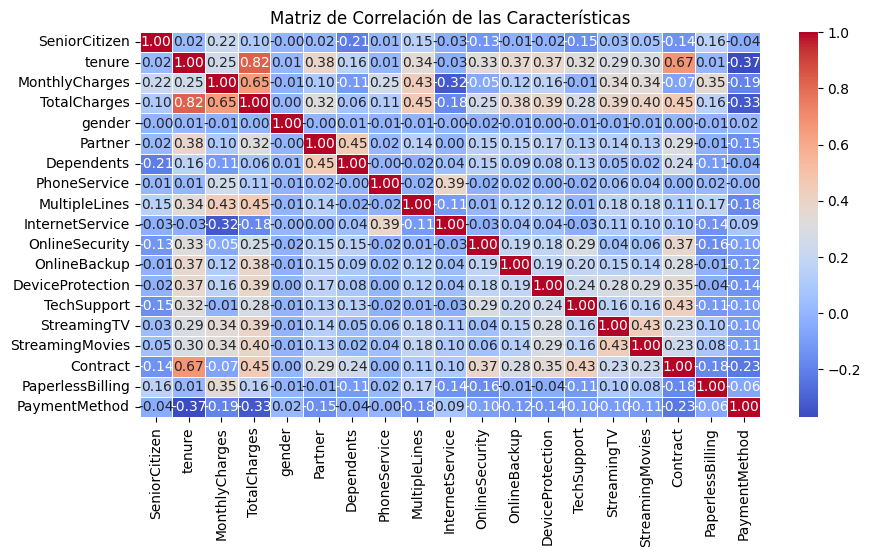

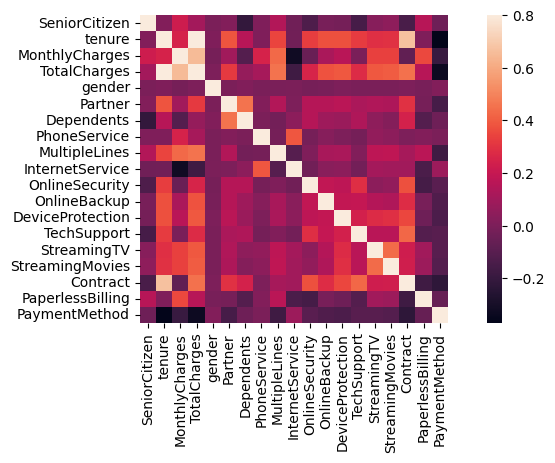

In [6]:
import seaborn as sns
cols = X.columns.tolist()  # Incluyendo todas las columnas, puedes modificar según tu necesidad

# Visualizar la matriz de correlación
correlation_matrix = X.corr()
plt.figure(figsize=(10, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlación de las Características')
plt.show()

f, ax = plt.subplots(figsize=(10, 4))
sns.heatmap(correlation_matrix, vmax=.8, square=True);

##Exportar el mejor modelo

In [11]:
from joblib import dump,load
indices_mejores_caracteristicas = [0,1,2,4,5,6,7,8,9,10,11,12,13,15,16,17,18]
X_mejores_caracteristicas = X.iloc[:, indices_mejores_caracteristicas]
mejor_modelo = LinearDiscriminantAnalysis()
modelo_release = mejor_modelo.fit(X_mejores_caracteristicas,y)
dump(modelo_release, '/content/Model_SVM_Credit_Card_Customer_Churn_Prediction.joblib')

['/content/Model_SVM_Credit_Card_Customer_Churn_Prediction.joblib']

### Cargar el modelo

In [12]:
#Cargar el modelo desde una ruta especifica
modelo_cargado = load('/content/Model_SVM_Credit_Card_Customer_Churn_Prediction.joblib')


In [13]:
#Predecir la rotación del cliente con las mejores caracteristicas
indices_mejores_caracteristicas = [0,1,2,4,5,6,7,8,9,10,11,12,13,15,16,17,18]
prediccion=modelo_cargado.predict(X.iloc[0:1, indices_mejores_caracteristicas])
if prediccion[0] == 0:
    print("Cliente no continuará con el servicio")
elif prediccion[0] == 1:
    print("El cliente continuará con el servicio")


Cliente no continuará con el servicio
